In [2]:
import sys
python_source_code_path = "C://Users//yuan//PycharmProjects//High-T-Angstrom-Method"
#python_source_code_path = "C://Users//NTRG lab//PycharmProjects//High-T-Angstrom-Method"

# change this to the folder where you store high_T_angstrom_method.py

sys.path.insert(1, python_source_code_path)

#from high_T_angstrom_method import batch_process_horizontal_lines,radial_1D_explicit,show_regression_results,simulation_result_amplitude_phase_extraction
from high_T_angstrom_method import show_sensitivity_results_sobol, sensitivity_model_parallel, sensitivity_model_output
from high_T_angstrom_method import interpolate_light_source_characteristic, interpolate_LB_temperatures
from high_T_angstrom_method import parallel_2nd_level_DOE, main_effects_2_level_DOE,interaction_effects_2_level_DOE,plot_main_effects_2nd_level_DOE
from high_T_angstrom_method import simulation_result_amplitude_phase_extraction,parallel_2nd_level_DOE,main_effect_2nd_level_DOE_one_row
import numpy as np
import matplotlib.pyplot as plt
import time
from SALib.sample import saltelli
from SALib.analyze import sobol
#from SALib.test_functions import Ishigami
import pandas as pd
#from SALib.sample.morris import sample
from SALib.sample.saltelli import sample
from tqdm import tqdm
from joblib import Parallel, delayed

import pickle
import itertools
import os

import matplotlib.ticker as mtick

code_directory = "G://My Drive//Current Projects//Angstrom Method//High Temperature Simulation//Jupyter Notebook//"



In [5]:
focal_shift = 0
V_DC = 4
sample_name = 'graphite_poco'

df_sample_cp_rho_alpha_all = pd.read_excel(code_directory + "sample specifications//sample properties.xlsx",
                                           sheet_name="sample properties")
df_sample_cp_rho_alpha = df_sample_cp_rho_alpha_all.query("sample_name=='{}'".format(sample_name))

df_solar_simulator_VQ = pd.read_csv(code_directory + "sample specifications//9_14_Amax_Fv_d_correlations.csv")

sigma_df = pd.read_csv(code_directory + "sample specifications//Lorentzian sigma.csv")

Amax, sigma_s, kvd, bvd = interpolate_light_source_characteristic(sigma_df, df_solar_simulator_VQ, focal_shift)

# # In sensitivity analysis, the entire light blocker is treated as a constant temperature source
# df_LB_details_all = pd.read_csv(code_directory + "sample specifications//LB temperature details sept 2020.csv")
# df_LB_temp = df_LB_details_all.query("Material == '{}'".format(sample_name))
# T_LB1_C,T_LB2_C,T_LB3_C, T_LB_mean_C = interpolate_LB_temperatures(focal_shift, V_DC, df_LB_temp)
T_LB_mean_C = 653

sample_information = {'sample_name':sample_name,'R':8.89/2/100,'t_z':1/32*2.5/100,'rho':float(df_sample_cp_rho_alpha['rho']),'cp_const':float(df_sample_cp_rho_alpha['cp_const']),'cp_c1':
                      float(df_sample_cp_rho_alpha['cp_c1']),'cp_c2':float(df_sample_cp_rho_alpha['cp_c2']),'cp_c3':float(df_sample_cp_rho_alpha['cp_c3']),'alpha_r':float(df_sample_cp_rho_alpha['alpha_r']),'alpha_z':float(df_sample_cp_rho_alpha['alpha_z']),'T_initial':800+273.15,'emissivity_front':0.90,'emissivity_back':0.92,'absorptivity_front':0.90,'absorptivity_back':0.92}

vacuum_chamber_setting = {'N_Rs':200,'T_sur1':T_LB_mean_C,'T_sur2':623,'R0':70,'focal_shift':focal_shift,'R_analysis':36}

numerical_simulation_setting = {'Nz':3,'Nr':200,'equal_grid':True,'N_cycle':25,
                                'vectorize':True,'Fo_criteria':1/4,'simulated_amp_phase_extraction_method':'sine','gap':4,'view_factor_setting':False,
                                'regression_result_type':'sensitivity_analysis','regression_module':'scipy.optimize-NM','regression_method':'amplitude-phase','regression_residual_converging_criteria':2e-5}

solar_simulator_settings = {'f_heating':None,'V_amplitude':2,'V_DC':V_DC,'rec_name':'2_level_DOE'}

light_source_property = {'Amax': Amax, 'sigma_s': sigma_s, 'kvd': kvd, 'bvd': bvd}

In [6]:
alpha_list = [float(df_sample_cp_rho_alpha['alpha_r'])*(1-0.05),float(df_sample_cp_rho_alpha['alpha_r'])*(1+0.05)]
Amax_list = [Amax*(1-0.15),Amax*(1+0.15)]
sigma_s_list = [sigma_s*(1-0.15), sigma_s*(1+0.15)]
emissivity_front_list = [0.63,0.77]
absorptivity_front_list = [0.63,0.77]
T_front_list = [(T_LB_mean_C+273.15)*(1-0.1),(T_LB_mean_C+273.15)*(1+0.1)]

f_heating_list = [0.2,0.15,0.1,0.08,0.04,0.02,0.01]
#f_heating_list = [0.1]
parameter_name_list = ['alpha_r','Amax','sigma_s','emissivity_front','absorptivity_front','T_sur1','f_heating']
full_factorial_combinations = itertools.product(alpha_list,Amax_list,sigma_s_list,emissivity_front_list,absorptivity_front_list,T_front_list, f_heating_list)


In [7]:
num_cores = 6
result_name = "graphite_NO_LB_sigma_Oct2020_10mHz_200mHz_2_level_DOE_"

df_results_amp_ratio_complete, df_results_phase_difference_complete = parallel_2nd_level_DOE(parameter_name_list, full_factorial_combinations,num_cores, result_name,code_directory,sample_information,vacuum_chamber_setting,solar_simulator_settings,light_source_property,numerical_simulation_setting)

  0%|                                                                                                                                                   | 0/448 [00:00<?, ?it/s]

No dump file found


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [23:40<00:00,  3.17s/it]


run complete, now dump files


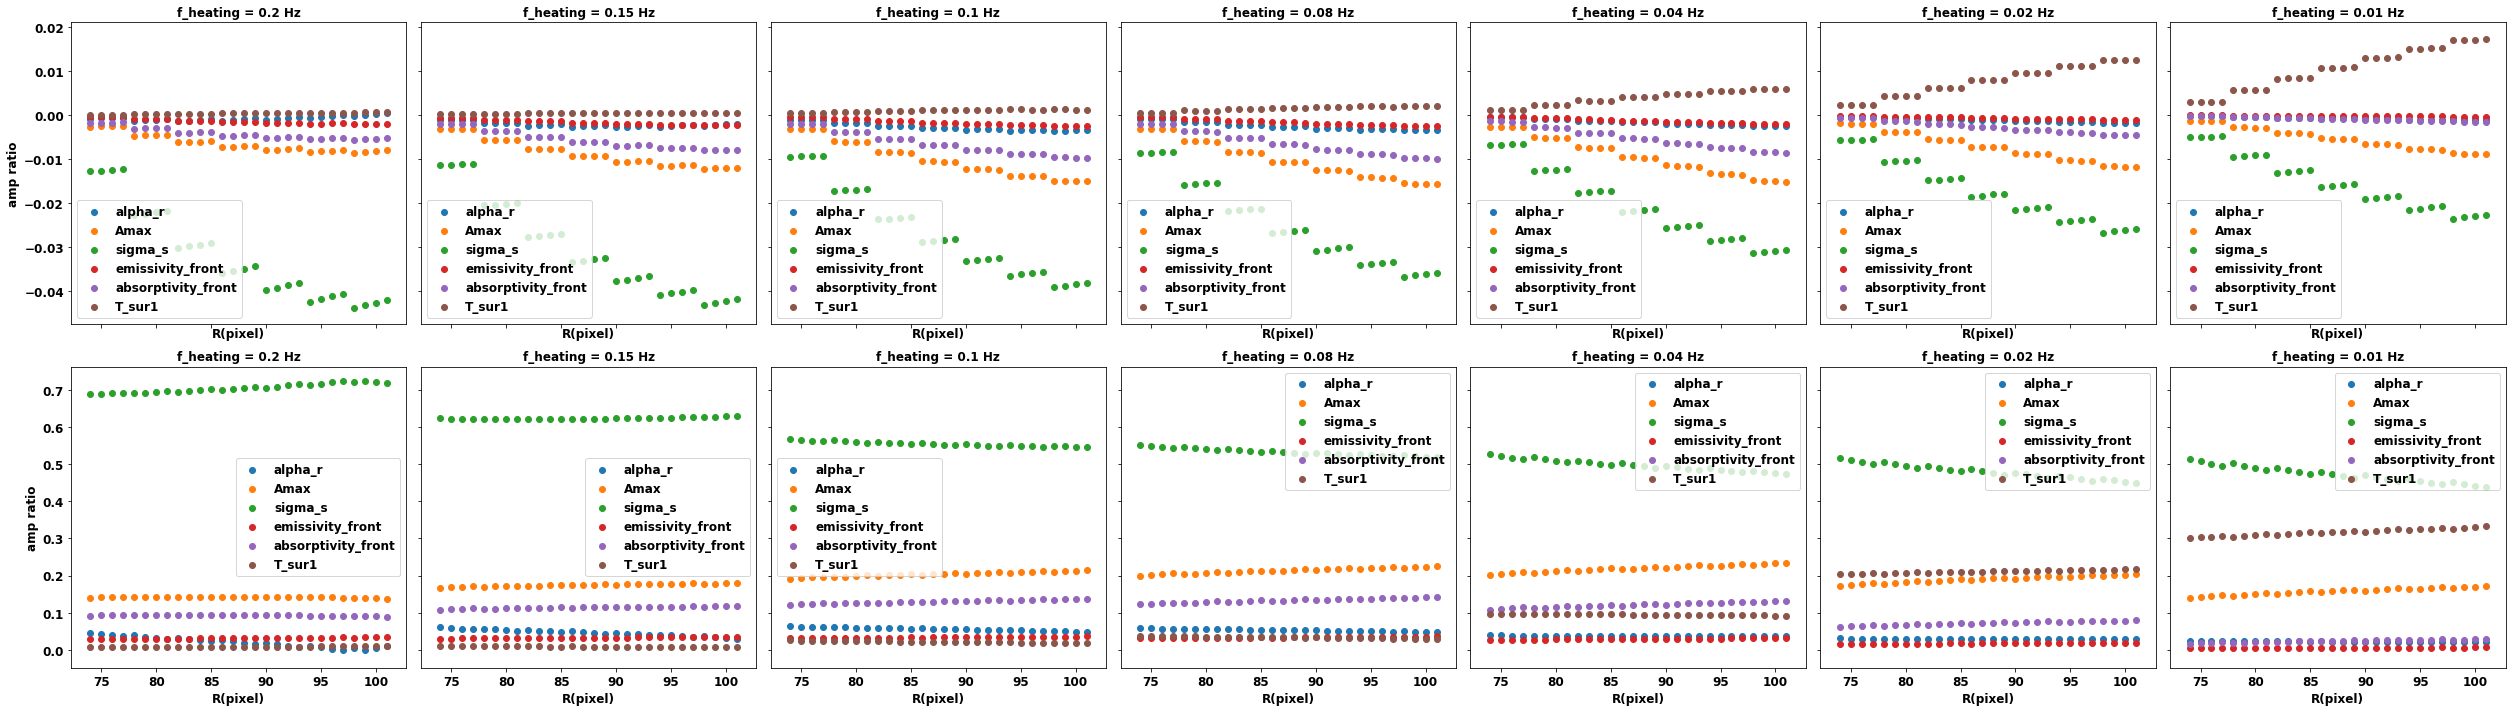

In [8]:
main_effect_2nd_level_DOE_one_row(df_results_amp_ratio_complete,'amp ratio', f_heating_list, parameter_name_list)

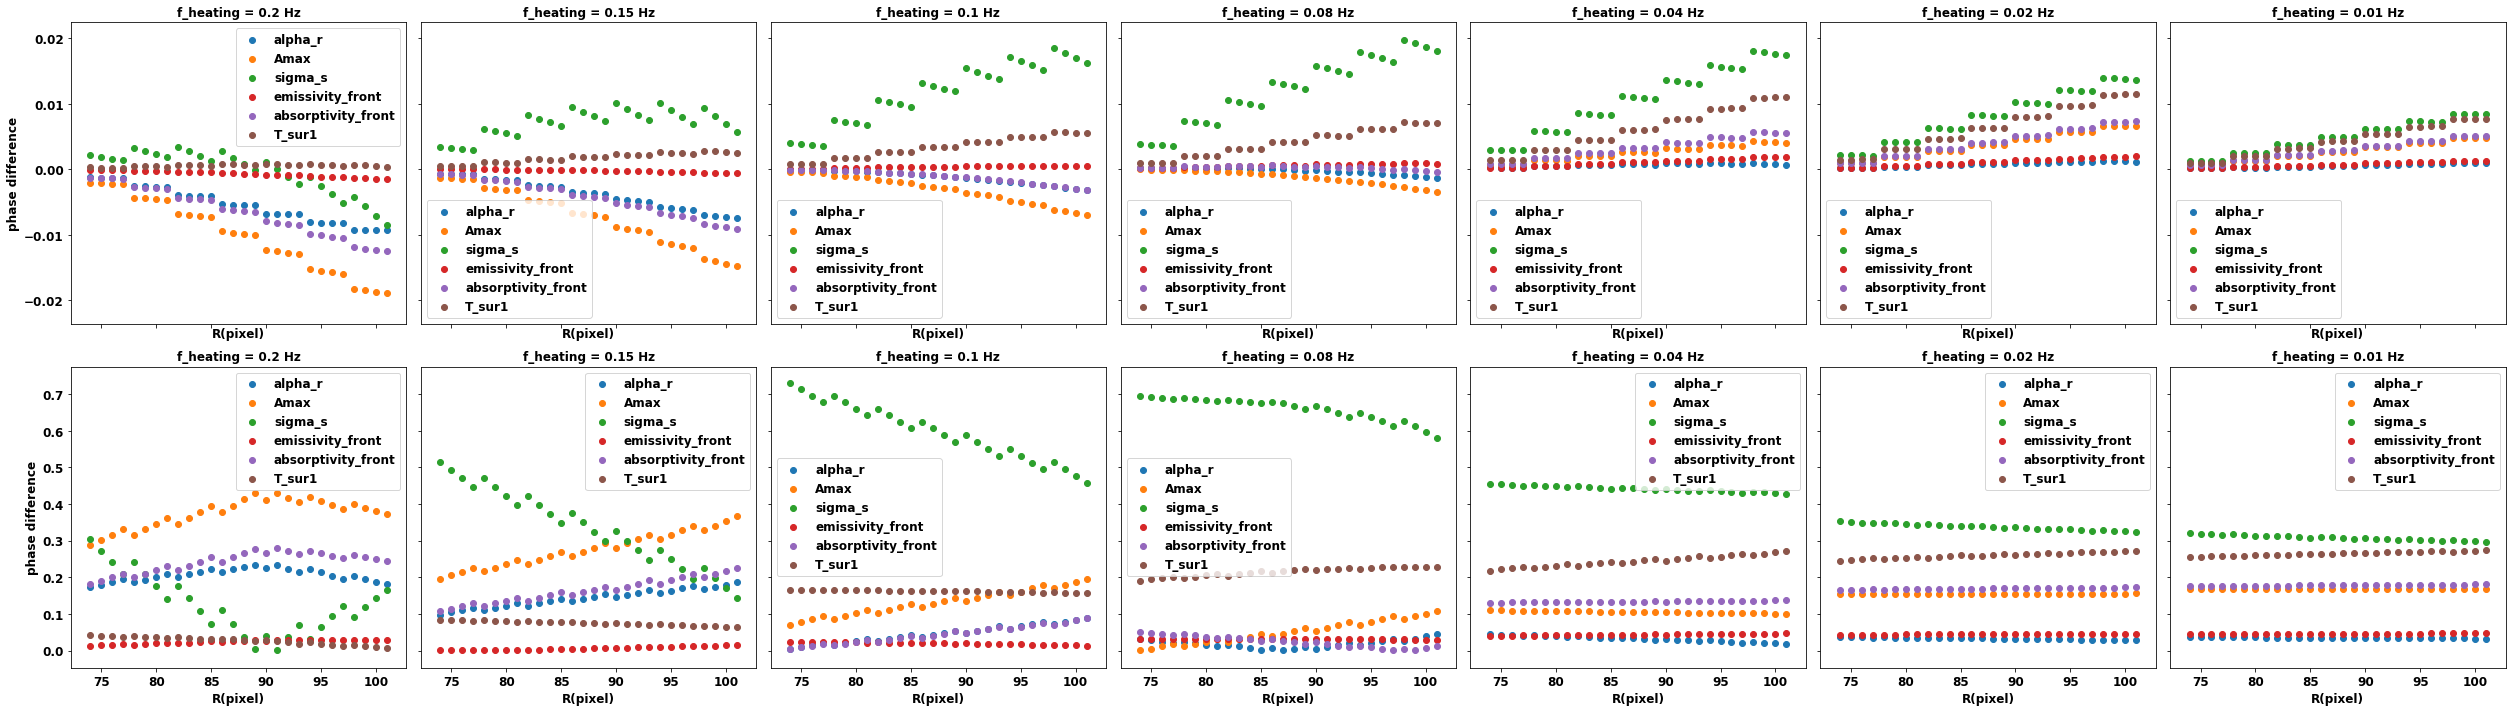

In [9]:
main_effect_2nd_level_DOE_one_row(df_results_phase_difference_complete,'phase difference', f_heating_list, parameter_name_list)